In [1]:
import math
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple, OrderedDict
from pathlib import Path

from tqdm.notebook import tqdm

In [2]:
INPUT_PATH = '../data/pku-autonomous-driving'
PRED_PATH = '../exp/car_pose_6dof/car_pose_default/results/predictions_045.csv'

In [3]:
def parse_pred_str(s):
    cars = np.array(s.split()).reshape([-1, 7])
    out = []
    for car in cars:
        car = {
            'rotation': car[0:3].astype(np.float64),
            'location': car[3:6].astype(np.float64),
            'score': car[-1].astype(np.float64),
        }
        out.append(car)
    return out


def create_camera_matrix():
    return np.array([
        [2304.5479, 0, 1686.2379, 0],
        [0, 2305.8757, 1354.9849, 0],
        [0, 0, 1., 0]
    ], dtype=np.float32)


def proj_point(p, calib):
    p = np.dot(calib[:,:3], p)
    p = p[:2] / p[2]
    return p

In [4]:
df = pd.read_csv(PRED_PATH)
calib = create_camera_matrix()

In [5]:
def imshow(img, boxes=None, figsize=(16,8)):
    plt.figure(figsize=figsize)
    ax = plt.axes()
    if boxes is not None:
        for bbox in boxes:
            rect = plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='g', linewidth=1)
            plt.gca().add_patch(rect)
    ax.imshow(img)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    
    
def add_blend_img(back, fore, trans=0.7, white_theme=False):
    if white_theme:
        fore = 255 - fore
    if fore.shape[0] != back.shape[0] or fore.shape[0] != back.shape[1]:
        fore = cv2.resize(fore, (back.shape[1], back.shape[0]))
    if len(fore.shape) == 2:
        fore = fore.reshape(fore.shape[0], fore.shape[1], 1)
    out = (back * (1. - trans) + fore * trans)
    out[out > 255] = 255
    out[out < 0] = 0
    return out.astype(np.uint8).copy()

In [6]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [7]:
def has_intersect(ct, mask, min_thresh=0.15):
    """
    ct - point (x, y)
    mask - inverted mask
    """
    x, y = int(round(ct[0])), int(round(ct[1]))
    h, w = mask.shape
    if x >= w or y >= h:
        return False
    # mask inverted: 1 - miss, 0 - inside mask
    out_of_mask = bool(mask[y,x])
    if out_of_mask:
        return False
    else:
        top    = 1 + mask[:y,x].nonzero()[0][-1] # max
        bottom = y + mask[y:,x].nonzero()[0][0] - 1  # min
        
        left_pxs = mask[y,:x].nonzero()[0]
        left   = 1 + left_pxs[-1] if left_pxs.sum() > 0 else 0 # max
        
        right_pxs = mask[y, x:].nonzero()[0]
        right  = x + right_pxs[0] - 1 if right_pxs.sum() > 0 else (w - 1)  # min
        
        w_mask = right - left
        h_mask = bottom - top
        if (x - left) / w_mask < min_thresh or (right - x) / w_mask < min_thresh:
            return False
        if (y - top) / h_mask < min_thresh or (bottom - y) / h_mask < min_thresh:
            return False
        return True

In [8]:
# def circ_mean(angles):    
#     av_sin = np.mean(np.sin(angles), axis=0)  
#     av_cos = np.mean(np.cos(angles), axis=0)  
#     ang_rad = np.arctan2(av_sin,av_cos)    
#     return ang_rad


# def average_duplicates(cars, min_dist=2.5):
#     cars_m = []
#     remove = []
#     n = len(cars)
#     for i in range(n):
#         if i in remove:
#             continue
#         for j in range(i+1, n):
#             loc0 = cars[i]['location']
#             loc1 = cars[j]['location']
#             dist_z = (loc0[-1] + loc1[-1]) / 2
#             dist = np.sqrt(np.square(loc1 - loc0).sum()) / dist_z
            
#             if dist < min_dist:
#                 car_m = {
#                     'location': np.mean([loc0, loc1], axis=0),
#                     'rotation': circ_mean([cars[i]['rotation'], cars[j]['rotation']]),
#                     'score': np.mean([cars[i]['score'], cars[j]['score']])
#                 }
#                 cars_m.append(car_m)
#                 remove.append(i)
#                 remove.append(j)
#                 break
                
#     cars_m += [c for i,c in enumerate(cars) if i not in remove]
#     dups = [c for i,c in enumerate(cars) if i in remove]
                
#     return cars_m, dups

In [9]:
def cars2str(cars):
    preds = []
    for car in cars:
        cc = [*car['rotation'], *car['location'], car['score']]
        cc_str = ' '.join([str(v) for v in cc])
        preds.append(cc_str)
    return ' '.join(preds)


def count_cars(dataframe):
    c = 0
    for i in range(len(dataframe)):
        v = dataframe.iloc[i,1]
        if v is not np.nan:
            c += len(v.split()) / 7
    return c

In [10]:
THRESH = 0.1

removed = 0
dead = {}
duplicates = {}
fixed_df = df.copy()

for i in tqdm(range(len(df))):
    pred_str = df.iloc[i,1]
    if pred_str is np.nan:
        continue
    img_id = df.iloc[i,0]
    mask_path = os.path.join(INPUT_PATH, 'test_masks', img_id+'.jpg')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    _, mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
    mask = (~mask / 255).astype(np.uint8)
    preds = parse_pred_str(pred_str)
    valid_cars = []
    need_fix = False
    
    for car in preds:
        ct = proj_point(car['location'], calib) # x,y
        if has_intersect(ct, mask, min_thresh=THRESH):
            car['ct'] = ct
            if not img_id in dead:
                dead[img_id] = []
            dead[img_id].append(car)
            removed += 1
            need_fix = True
        else:
            valid_cars.append(car)
            
    if need_fix:
        pred_str = cars2str(valid_cars)
        fixed_df.iloc[i,1] = pred_str
        
print('Removed: %d' % removed)


Removed: 269


In [11]:
count_cars(df), count_cars(fixed_df)

(13942.0, 13673.0)

In [12]:
fixed_df.to_csv('predicitions_fixed.csv', index=False)

In [13]:
!cat predicitions_fixed.csv | head -n 2

ImageId,PredictionString
ID_18fb86d04,
cat: write error: Broken pipe


In [14]:
img_ids = iter(dead.keys())

ID_afe07078f


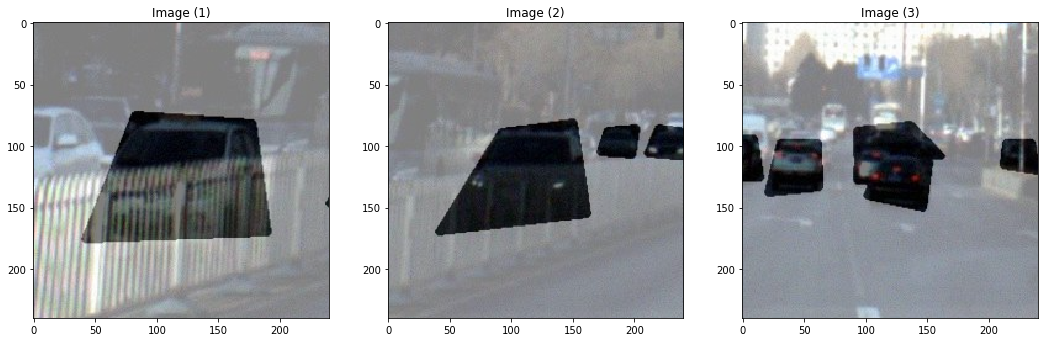

In [15]:
img_id = next(img_ids)
print(img_id)

img_path = os.path.join(INPUT_PATH, 'test_images', img_id+'.jpg')
img = cv2.imread(img_path)[:,:,::-1]

mask_path = os.path.join(INPUT_PATH, 'test_masks', img_id+'.jpg')
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

check = []
for car in dead[img_id]:    
    ct = car['ct']
    x,y = int(ct[0]), int(ct[1])
    h,w = mask.shape
    s = 120
    blend = add_blend_img(img, mask, trans=0.5, white_theme=True)
    blend = blend[max(0,y-s):min(y+s, h-1), max(0,x-s):min(x+s, w-1),:]
    check.append(blend)
    
show_images(check)